# Combatting Partisan Homogenization in New Content Recommenders - Baselines(Tf-Idf)

In [1]:
# to do
# test with our prototypes and our actual topic labelled data
# use immigration and guns topic, prototypes have to have differing stance variation

## Table of Contents 
### [Clustering Documents, Filtering and Vectorization](#Clustering_Documents_Filtering_Vectorization)
### [Baseline 1 - (Cluster Similarity vs Model Performance)](#Cluster_Similarity_vs_Model_Performance)
### [Baseline 2 - (Online Setting Performance)](#Online_Setting_Performance)
### [Baseline 3 - (Single Cluster Online Setting Performance)](#Single_Cluster_Online_Setting_Performance)
### [Baseline 4 - (Regularization vs Online Setting Performance)](#Regularization_vs_Online_Setting_Performance)
### [Baseline 5 - (Learning Rate vs Online Setting Performance)](#Learning_Rate_vs_Online_Setting_Performance)
### [Baseline 6 - (Online Setting Mixed Data Performance)](#Online_Setting_Mixed_Data_Performance)
### [Baseline 7 - (Learning Rate vs Online Setting Mixed Data Performance)](#Learning_Rate_vs_Online_Setting_Mixed_Data_Performance)

#### Important:
* Heterogenous User:
    * Conservative on Cluster 1 but Liberal on Cluster 2
* Homogeneous User:
    * Conservative on Cluster 1 and Cluster 2

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

In [4]:
from general_utils import timer

from config import RANDOM_SEED

from preprocess_utils import preprocess_texts, tfidf_vectorization, dimensionality_reduction

from clustering_utils import run_clustering, get_cluster_sizes, score_cluster, get_cluster_pairs, get_pairwise_dist, cluster2doc, filter_clusters, get_top_100_clusterpairs

from data_utils import load_data, sample_data, balanced_sampling, create_train_test

from metrics_utils import calculate_avg_precision, calculate_map, get_scores, get_scores_wot, calculate_avg_precision_param_variation, calculate_map_param_variation

from model_utils import ( run_model, 
                         run_bs1_train_all, 
                         run_online_setting_active, 
                         run_bs2_train_all, 
                         run_bs3_train_all, 
                         run_bs4_train_all, 
                         run_bs5_train_all, 
                         run_bs6_train_all, 
                         run_bs7_train_all)

from plotters_baseline import ( plot_size_dist, 
                               bsl1_sim_vs_score_all_users, 
                               regularization_plot_helper, 
                               plot_regularization_vs_metrics_at_k, 
                               combine_scores_reg_vs_metrics_at_k, 
                               plot_regularization_vs_metrics_at_k_cumu, 
                               plot_lr_vs_metrics_at_k, 
                               plot_lr_vs_metrics_at_k_cumu, 
                               plot_online_setting_per_clusterpair, 
                               plot_helper_all_cp, 
                               plot_all_cp_online, 
                               plot_all_cp_singlecluster, 
                               plot_helper_scp, 
                               plot_single_cluster_performance, 
                               plot_mixed_data_all_cp_perf, 
                               plot_helper_md, 
                               plot_prec_sep, 
                               plot_mixed_data_performance_per_cluster, 
                               plot_mixed_data_performance, 
                               combine_scores_cumu_online_setting,
                               plot_mixed_cluster_cumulative, 
                               plot_online_learning_cumulative, 
                               plot_single_cluster_cumulative, 
                               plot_mixed_data_all_cp_perf, 
                               lr_mixed_plot_helper, 
                               plot_lr_vs_metrics_at_k_mixed, 
                               plot_mixed_data_all_cp_precis_lr, 
                               plot_mixed_cluster_cumulative_per_cluster  )   

....... Initializing Settings ..... 
Random_Seed Chosen : 15112


In [5]:
warnings.filterwarnings('ignore')

In [6]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.grid'] = True

# Main Components

1) Data Loading  
2) Sampling  
3) Text Preprocessing  
4) Vectorization  
5) Dimensionality Reductions  
6) Clustering  
7) Clustering Performance Check  
8) Cluster Filtering  
9) Pairwise Selection  
10) Model Training and Performance  
11) Pairwise score analysis  

## Clustering Documents, Filtering and Vectorization <a class="anchor" id="Clustering_Documents_Filtering_Vectorization"></a>

Index(['article_id', 'url', 'title', 'text', 'source', 'source_partisan_score',
       'tweet_id', 'tweet_screen_name', 'tweet_created_at', 'tweet_text'],
      dtype='object')
Df original shape : (921037, 10)
Df shape after dropping nan text : (919430, 10)
Df shape after dropping duplicate articles based on title : (912084, 10)
Df shape after dropping 0 stance articles : (630425, 10)

Finished running 'load_data' in 0.4753 mins


Finished running 'sample_data' in 0.0020 mins

Sampled Size: 100000
Running : select_first10
Running : to_lower
Running : remove_punc
Running : remove_small_words
Running : remove_spaces

Finished running 'preprocess_texts' in 0.3577 mins

vocab_size : 16829

Finished running 'tfidf_vectorization' in 0.1810 mins


Shape Before DIM REDUC : (100000, 16829)
Shape After DIM REDUC : (100000, 16829)

Finished running 'dimensionality_reduction' in 0.9992 mins


Running KMEANS Clustering with k=1000

Finished running 'run_clustering' in 0.2247 mins


Finished running

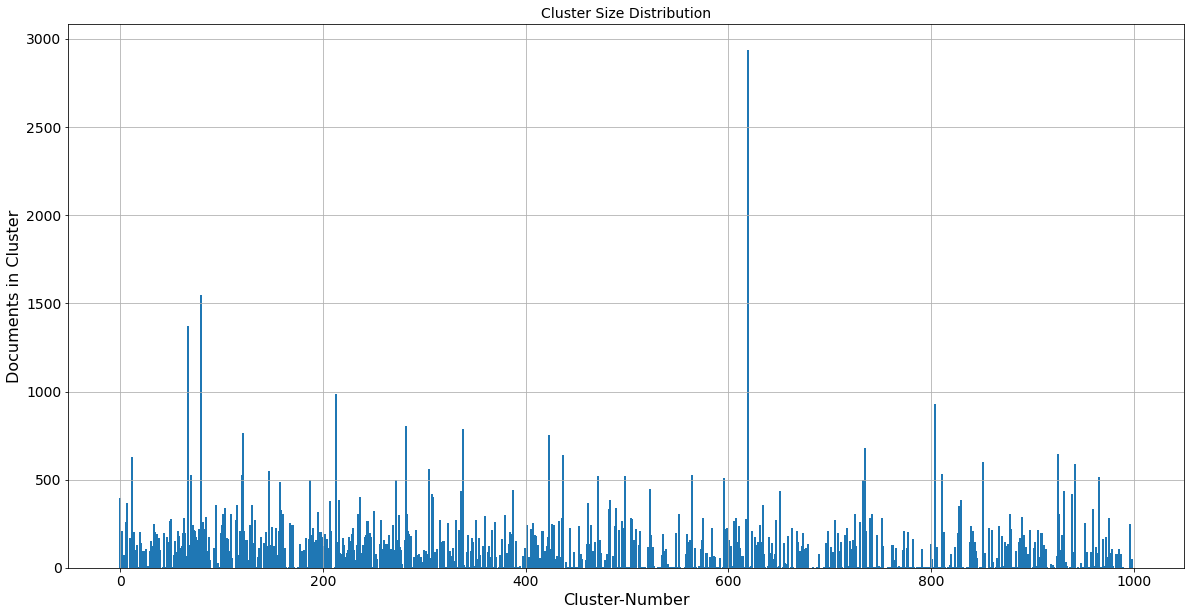


Finished running 'get_pairwise_dist' in 0.0001 mins


Number of Cluster Pairs : 499500

Finished running 'get_cluster_pairs' in 0.0005 mins

499500


In [7]:
path = "../articles.csv"

main_df = load_data(path)

sampled_df = sample_data(df=main_df,sample_size=100000,seed=RANDOM_SEED)
print("Sampled Size: %s" %str(sampled_df.shape[0]))

sampled_df["processed_text"] = preprocess_texts(text_lists=sampled_df["text"])

vectors,vocab,tfidf_vectorizer = tfidf_vectorization(df=sampled_df,min_df=50,max_df=0.75,seed=RANDOM_SEED)

reduced_vectors = dimensionality_reduction(vectors=vectors,mode="SVD_LSA",dim=500,seed=RANDOM_SEED)

clusters,cluster_clf = run_clustering(vectors=reduced_vectors,seed=RANDOM_SEED,num_clusters=1000,clus_type="kmeans")

cluster_sizes = get_cluster_sizes(cluster_clf)

plot_size_dist(cluster_sizes)

cluster_pair_dist_mat = get_pairwise_dist(cluster_clf,dist_type="cosine")

cluster_pairs = get_cluster_pairs(num_clusters=1000)
print(len(cluster_pairs))

In [8]:
doc_2_cluster_map = cluster2doc(num_texts=sampled_df.shape[0],cluster_labels=cluster_clf.labels_)


Finished running 'cluster2doc' in 0.0005 mins



In [9]:
filtered_cluster_pairs = filter_clusters(cluster_pairs=cluster_pairs,
                                        doc_2_cluster_map=doc_2_cluster_map,
                                        cluster_sizes=cluster_sizes,
                                        partisan_scores=sampled_df["binary_ps"].tolist(),
                                        min_size=450,
                                        max_size=5000,
                                        min_partisan_size=0.4)

print("Filtered CLustered Pairs : %s" %str(len(filtered_cluster_pairs)))


Finished running 'filter_clusters' in 0.0708 mins

Filtered CLustered Pairs : 55


In [10]:
top100 = get_top_100_clusterpairs(cluster_pairs=filtered_cluster_pairs,dist_matrix=cluster_pair_dist_mat,reverse=True)


Finished running 'get_top_100_clusterpairs' in 0.0000 mins



## Baseline 1 : <a class="anchor" id="Cluster_Similarity_vs_Model_Performance"></a>

In [199]:
df_result = run_bs1_train_all(X = reduced_vectors,
                          cluster_2_doc_map = doc_2_cluster_map ,
                          df = sampled_df ,
                          cluster_pairs = top100,
                          cosine_mat = cluster_pair_dist_mat,
                          thresholds = [0.5,0.7,0.9],
                          user_type="Heterogeneous")

Training model for cluster pair : 0

Finished running 'run_model' in 0.0099 mins

Training model for cluster pair : 1

Finished running 'run_model' in 0.0073 mins

Training model for cluster pair : 2

Finished running 'run_model' in 0.0091 mins

Training model for cluster pair : 3

Finished running 'run_model' in 0.0058 mins

Training model for cluster pair : 4

Finished running 'run_model' in 0.0057 mins

Training model for cluster pair : 5

Finished running 'run_model' in 0.0085 mins

Training model for cluster pair : 6

Finished running 'run_model' in 0.0055 mins

Training model for cluster pair : 7

Finished running 'run_model' in 0.0083 mins

Training model for cluster pair : 8

Finished running 'run_model' in 0.0077 mins

Training model for cluster pair : 9

Finished running 'run_model' in 0.0082 mins

Training model for cluster pair : 10

Finished running 'run_model' in 0.0092 mins

Training model for cluster pair : 11

Finished running 'run_model' in 0.0075 mins

Training model

In [200]:
df_result_homog = run_bs1_train_all(X = reduced_vectors,
                          cluster_2_doc_map = doc_2_cluster_map ,
                          df = sampled_df ,
                          cluster_pairs = top100,
                          cosine_mat = cluster_pair_dist_mat,
                          thresholds = [0.5,0.7,0.9],
                          user_type="Homogeneous")

Training model for cluster pair : 0

Finished running 'run_model' in 0.0082 mins

Training model for cluster pair : 1

Finished running 'run_model' in 0.0081 mins

Training model for cluster pair : 2

Finished running 'run_model' in 0.0082 mins

Training model for cluster pair : 3

Finished running 'run_model' in 0.0060 mins

Training model for cluster pair : 4

Finished running 'run_model' in 0.0063 mins

Training model for cluster pair : 5

Finished running 'run_model' in 0.0080 mins

Training model for cluster pair : 6

Finished running 'run_model' in 0.0059 mins

Training model for cluster pair : 7

Finished running 'run_model' in 0.0087 mins

Training model for cluster pair : 8

Finished running 'run_model' in 0.0079 mins

Training model for cluster pair : 9

Finished running 'run_model' in 0.0077 mins

Training model for cluster pair : 10

Finished running 'run_model' in 0.0078 mins

Training model for cluster pair : 11

Finished running 'run_model' in 0.0082 mins

Training model

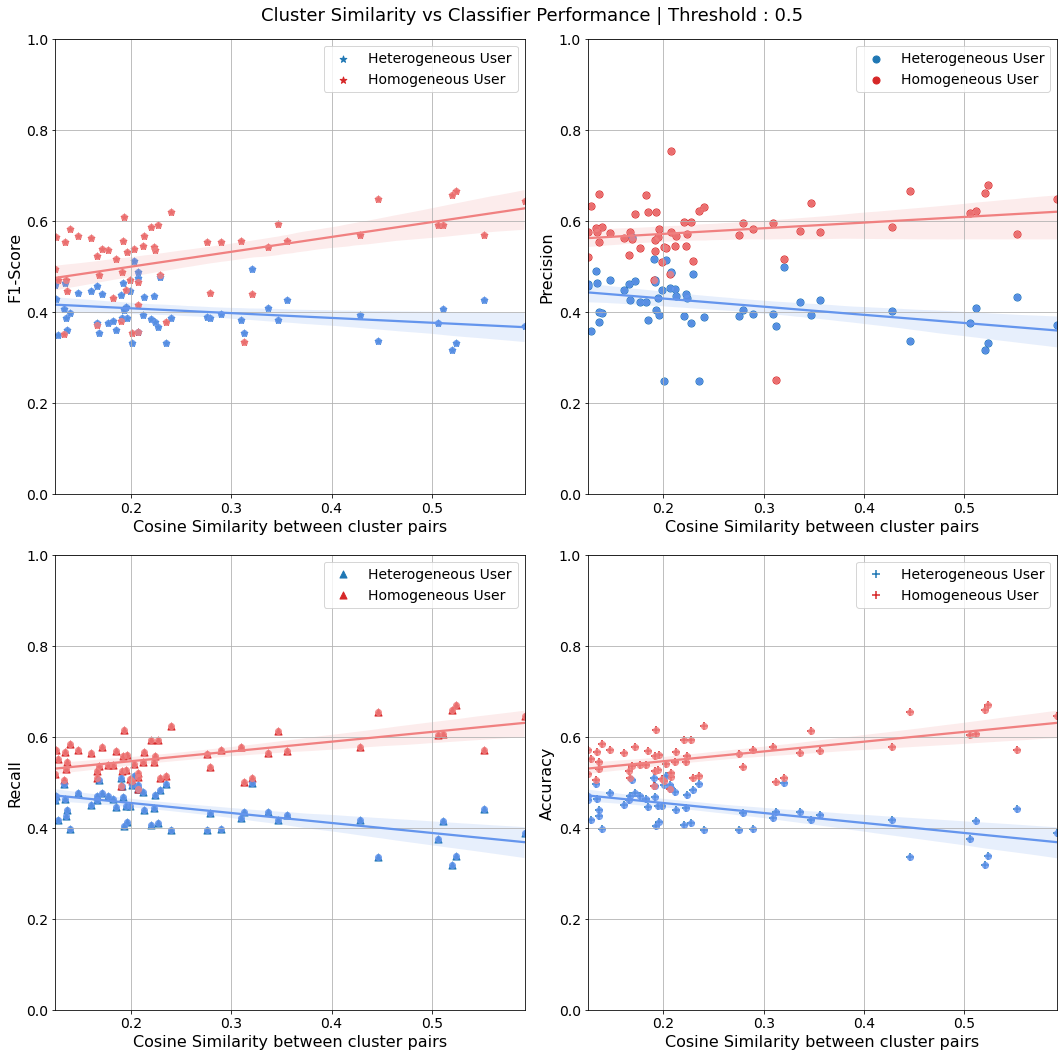


Finished running 'bsl1_sim_vs_score_all_users' in 0.0195 mins



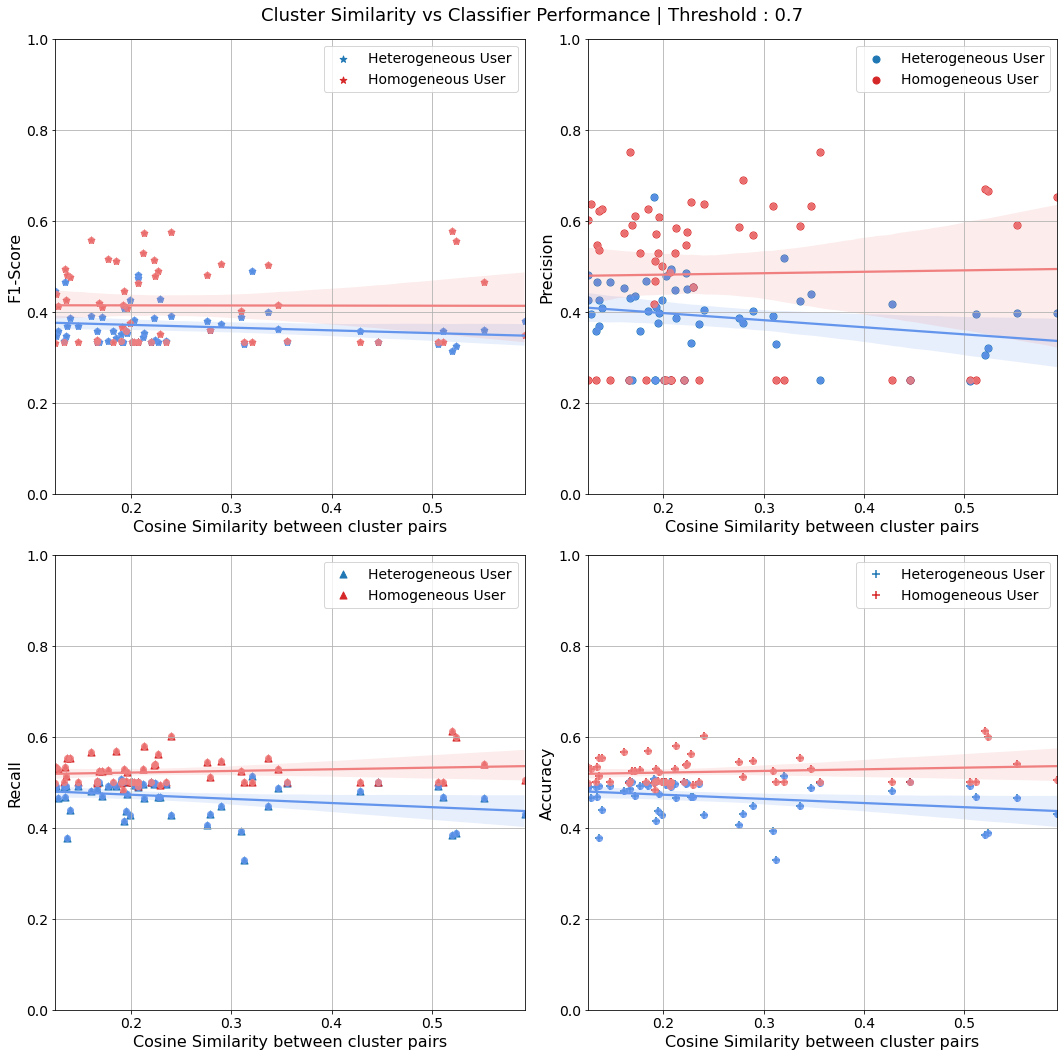


Finished running 'bsl1_sim_vs_score_all_users' in 0.0187 mins



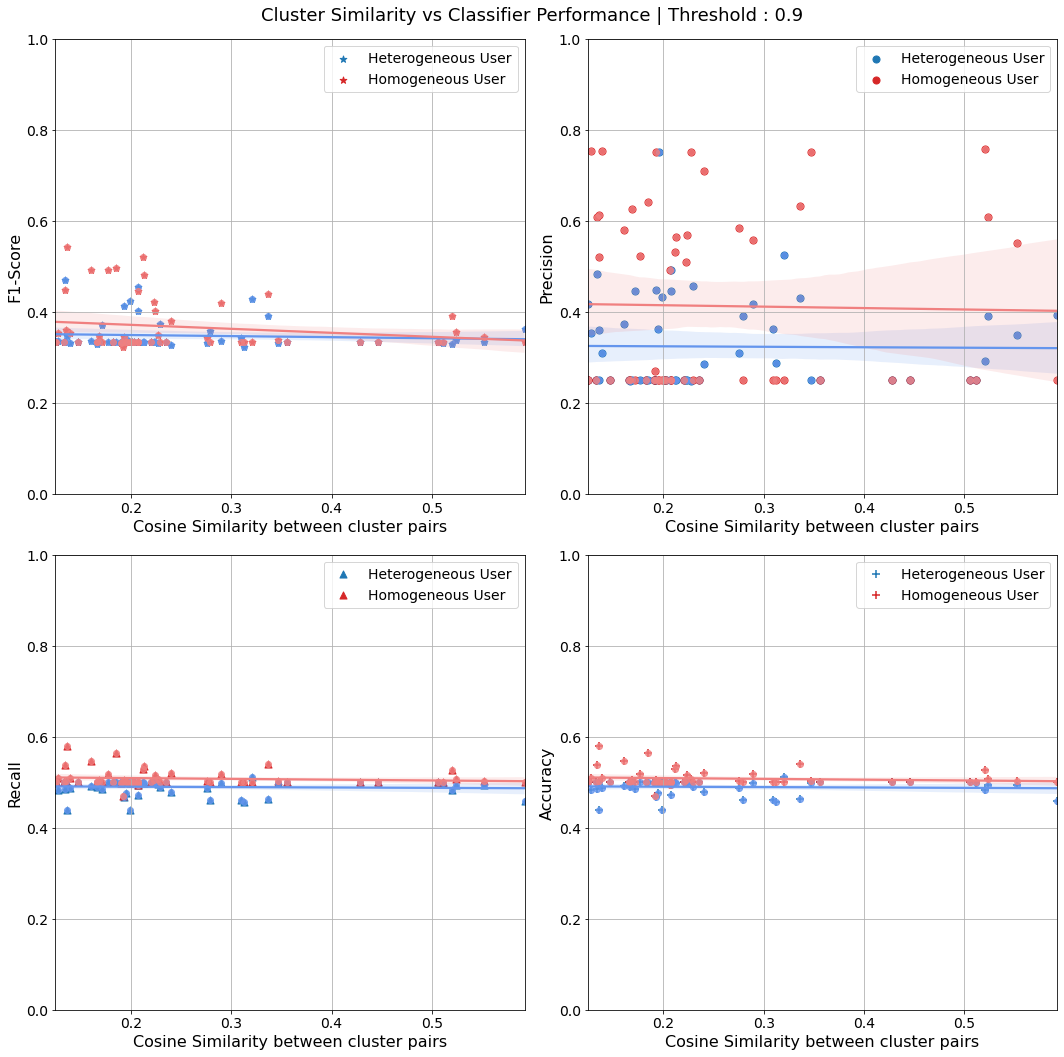


Finished running 'bsl1_sim_vs_score_all_users' in 0.0186 mins



In [201]:
for threshold in [0.5,0.7,0.9]:
    bsl1_sim_vs_score_all_users(df_results_hetero=df_result,
                                df_results_homo=df_result_homog,
                                threshold=threshold)

<!-- ## Online Learning Setting - Active Learning Setting (Performance Measured on Held Out Validation Dataset) -->

## Baseline 2 : <a class="anchor" id="Online_Setting_Performance"></a>

In [202]:
hetero_scores,df_res_map_hetero = run_bs2_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Heterogeneous")

Training model for cluster pair : (423, 437)
Training model for cluster pair : (338, 735)
Training model for cluster pair : (423, 498)
Training model for cluster pair : (437, 735)
Training model for cluster pair : (735, 942)
Training model for cluster pair : (423, 735)
Training model for cluster pair : (437, 942)
Training model for cluster pair : (423, 942)
Training model for cluster pair : (338, 423)
Training model for cluster pair : (338, 437)
Training model for cluster pair : (305, 338)
Training model for cluster pair : (338, 942)
Training model for cluster pair : (498, 735)
Training model for cluster pair : (70, 121)
Training model for cluster pair : (70, 187)
Training model for cluster pair : (305, 735)
Training model for cluster pair : (437, 498)
Training model for cluster pair : (338, 498)
Training model for cluster pair : (498, 942)
Training model for cluster pair : (70, 735)
Training model for cluster pair : (121, 187)
Training model for cluster pair : (121, 735)
Training mode

In [203]:
homo_scores, df_res_map_homo =  run_bs2_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Homogeneous")

Training model for cluster pair : (423, 437)
Training model for cluster pair : (338, 735)
Training model for cluster pair : (423, 498)
Training model for cluster pair : (437, 735)
Training model for cluster pair : (735, 942)
Training model for cluster pair : (423, 735)
Training model for cluster pair : (437, 942)
Training model for cluster pair : (423, 942)
Training model for cluster pair : (338, 423)
Training model for cluster pair : (338, 437)
Training model for cluster pair : (305, 338)
Training model for cluster pair : (338, 942)
Training model for cluster pair : (498, 735)
Training model for cluster pair : (70, 121)
Training model for cluster pair : (70, 187)
Training model for cluster pair : (305, 735)
Training model for cluster pair : (437, 498)
Training model for cluster pair : (338, 498)
Training model for cluster pair : (498, 942)
Training model for cluster pair : (70, 735)
Training model for cluster pair : (121, 187)
Training model for cluster pair : (121, 735)
Training mode


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins



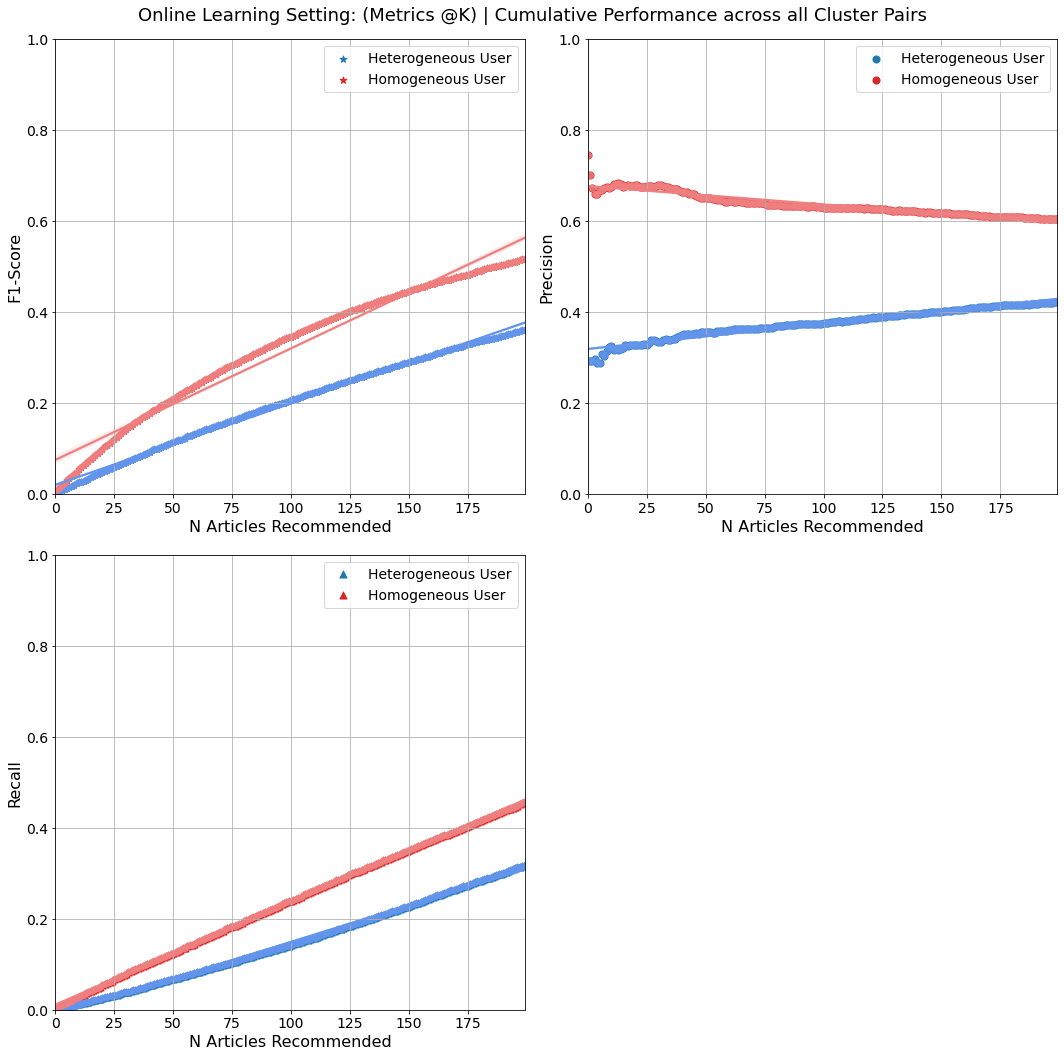


Finished running 'plot_online_setting_per_clusterpair' in 0.0181 mins


Finished running 'plot_online_learning_cumulative' in 0.0182 mins



In [206]:
plot_online_learning_cumulative(homo_scores,hetero_scores,active=False)

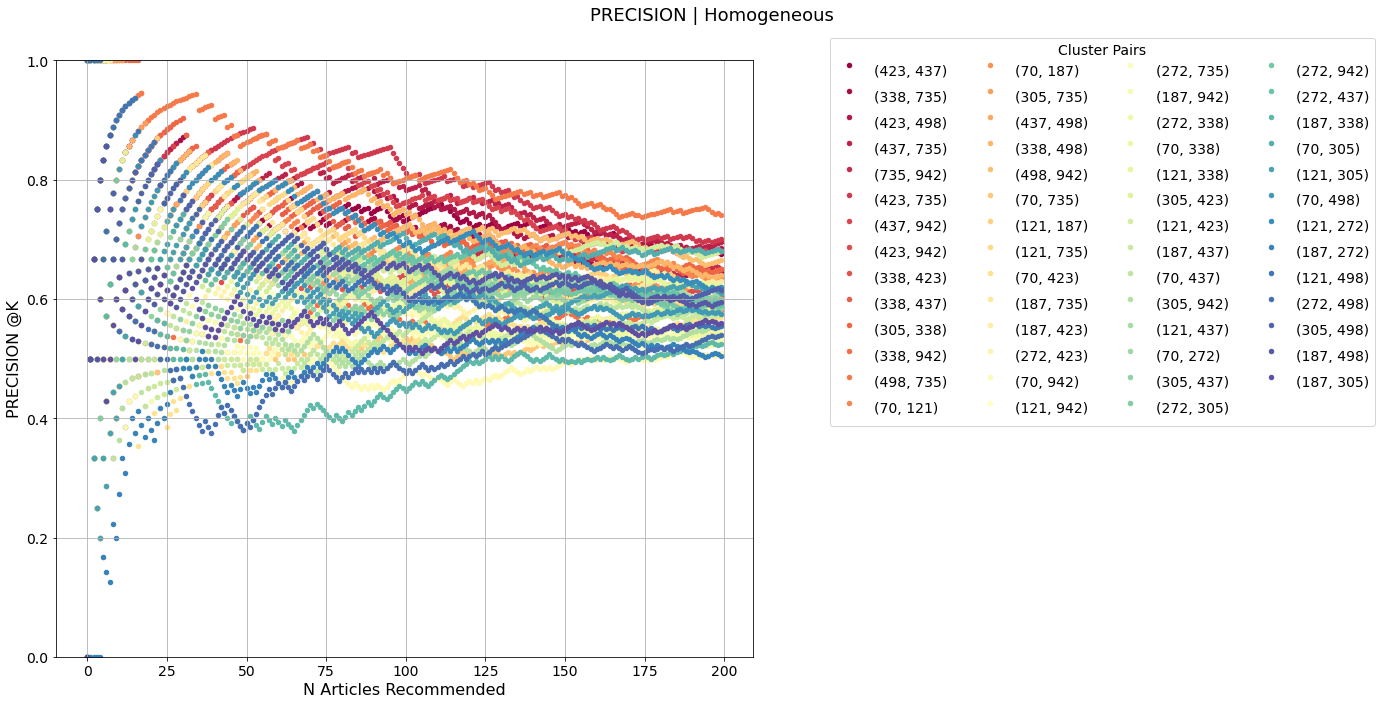


Finished running 'plot_all_cp_online' in 0.0351 mins



In [208]:
plot_all_cp_online(homo_scores,user_type="Homogeneous",metric="precision")

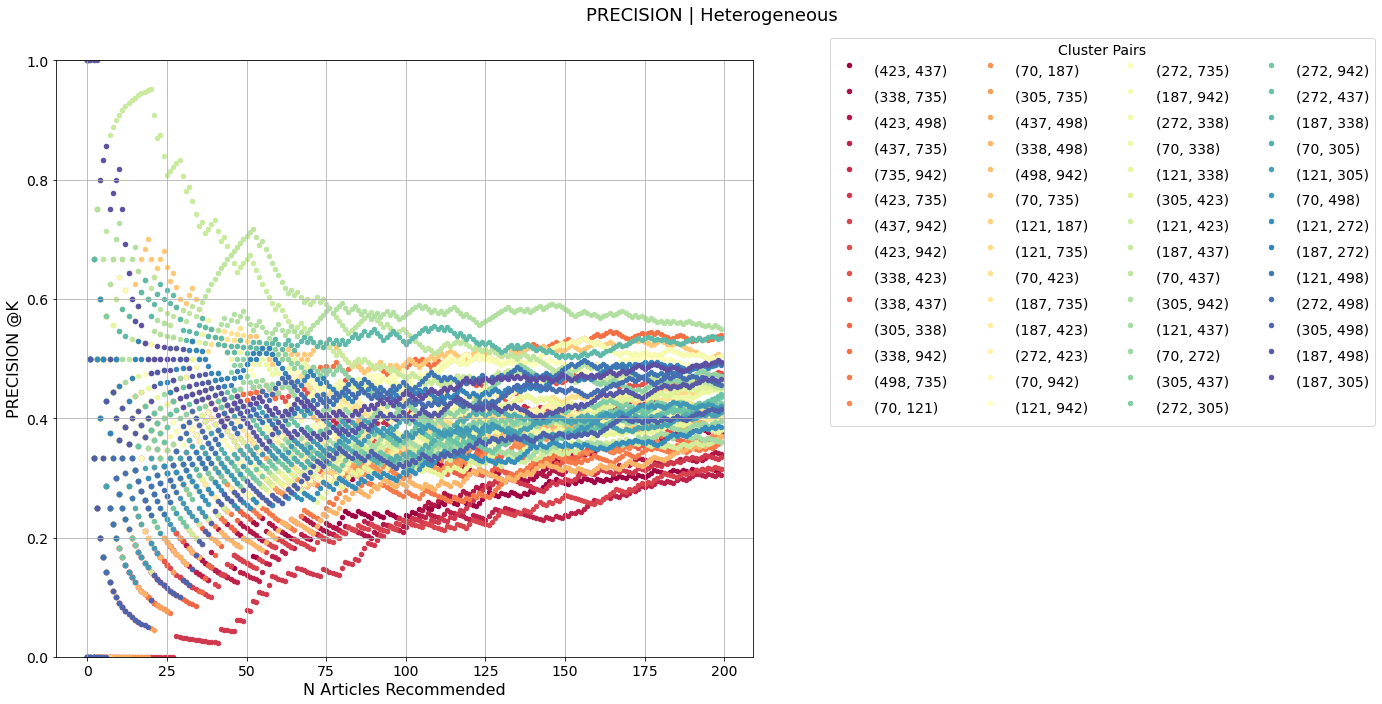


Finished running 'plot_all_cp_online' in 0.0351 mins



In [209]:
plot_all_cp_online(hetero_scores,user_type="Heterogeneous",metric="precision")

In [210]:
avg_presc_homo = calculate_avg_precision(homo_scores,mode="single")

In [211]:
np.mean(avg_presc_homo)

0.6360724363852508

In [212]:
avg_presc_hetero = calculate_avg_precision(hetero_scores,mode="single")

In [213]:
np.mean(avg_presc_hetero)

0.37343009417901823

## Baseline 3 :  <a class="anchor" id="Single_Cluster_Online_Setting_Performance"></a>

In [214]:
hetero_scores = run_bs3_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Heterogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [215]:
homo_scores =  run_bs3_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Homogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins



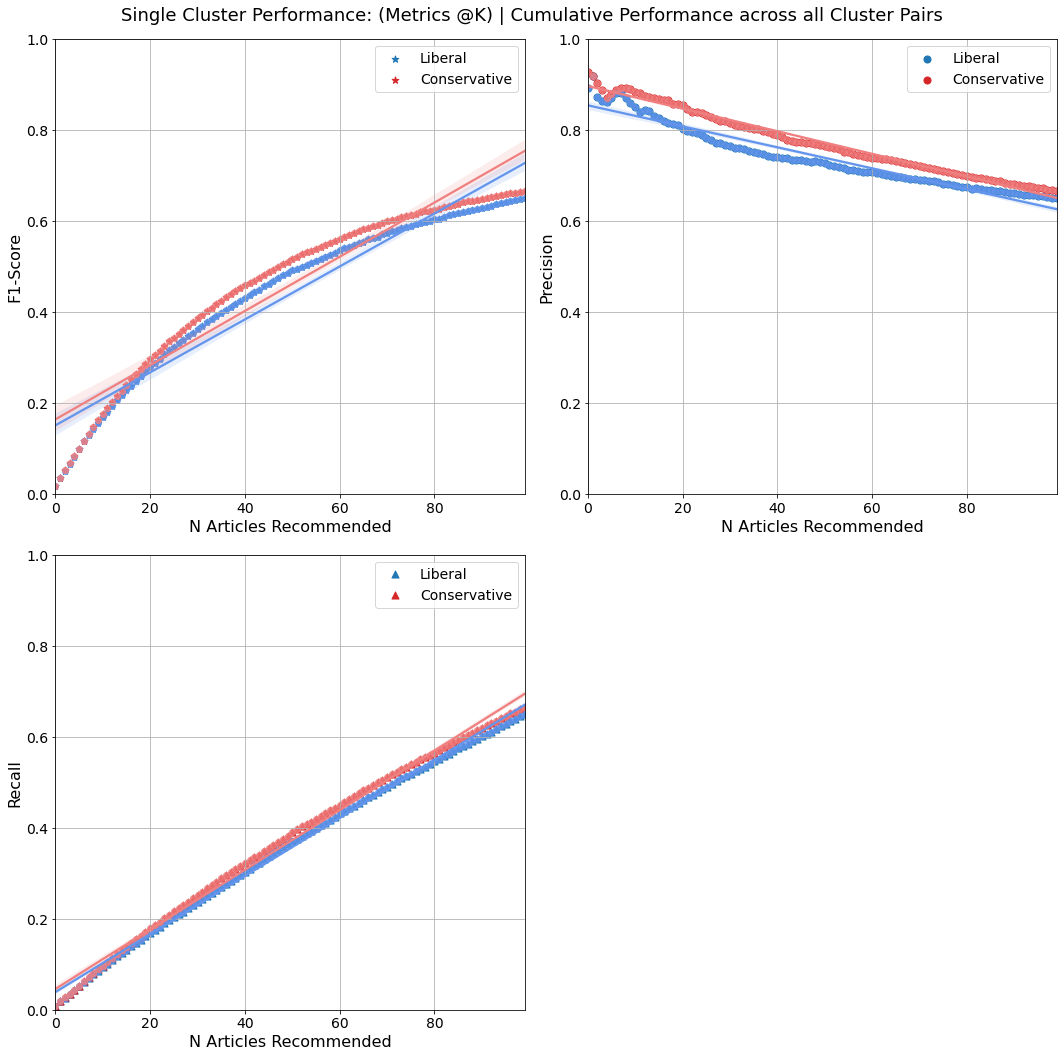


Finished running 'plot_single_cluster_performance' in 0.0169 mins


Finished running 'plot_single_cluster_cumulative' in 0.0169 mins



In [217]:
plot_single_cluster_cumulative(homo_scores,hetero_scores)

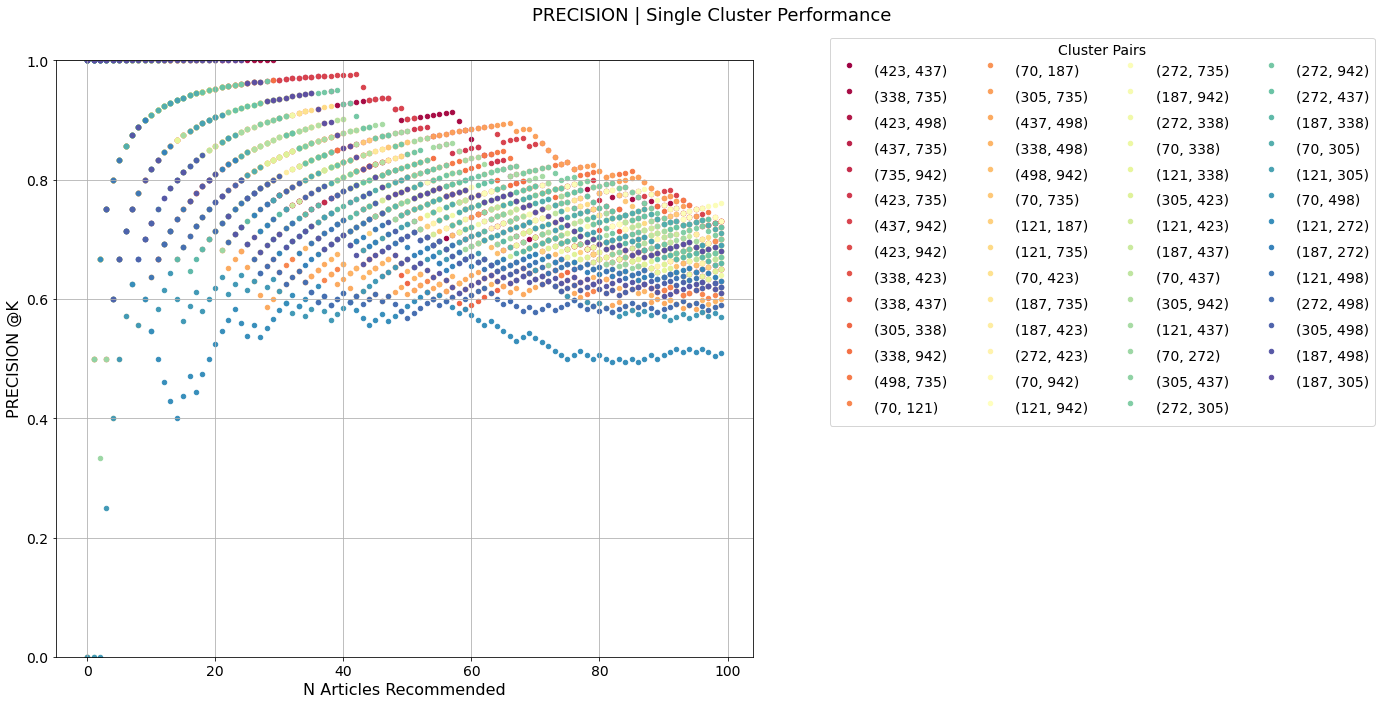


Finished running 'plot_all_cp_singlecluster' in 0.0340 mins



In [218]:
plot_all_cp_singlecluster(homo_scores)

In [219]:
avg_presc_homo = calculate_avg_precision(homo_scores,mode="single")

In [220]:
np.mean(avg_presc_homo)

0.7731548988829844

## Baseline 4: <a class="anchor" id="Regularization_vs_Online_Setting_Performance"></a>

In [221]:
hetero_scores = run_bs4_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous",
                                 reg_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [222]:
homo_scores = run_bs4_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous",
                                 reg_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0002 mins



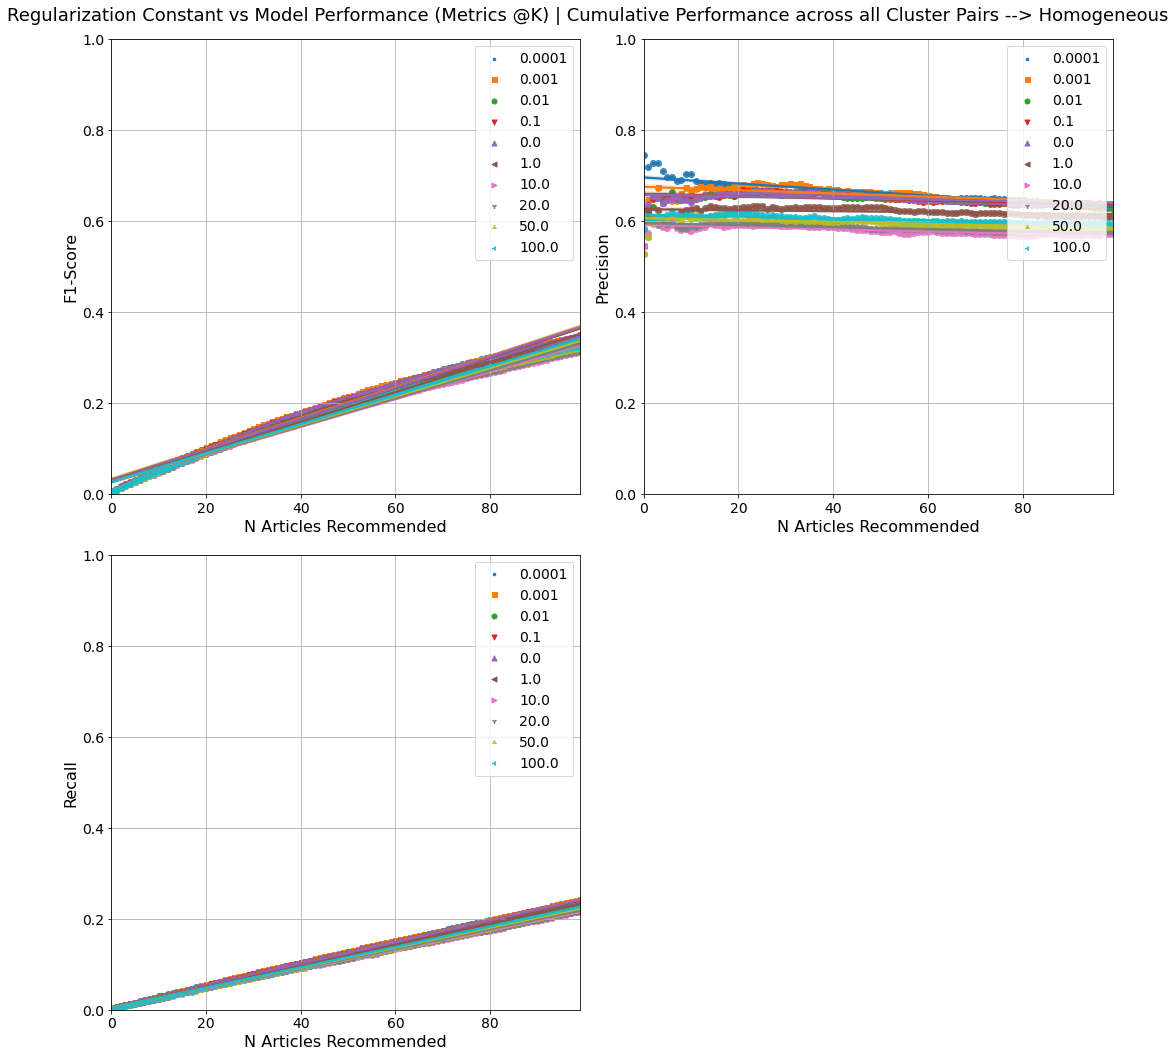


Finished running 'plot_regularization_vs_metrics_at_k' in 0.0578 mins


Finished running 'plot_regularization_vs_metrics_at_k_cumu' in 0.0579 mins



In [223]:
plot_regularization_vs_metrics_at_k_cumu(homo_scores,
                                         regularization_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0],
                                         user_type="Homogeneous")


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0001 mins



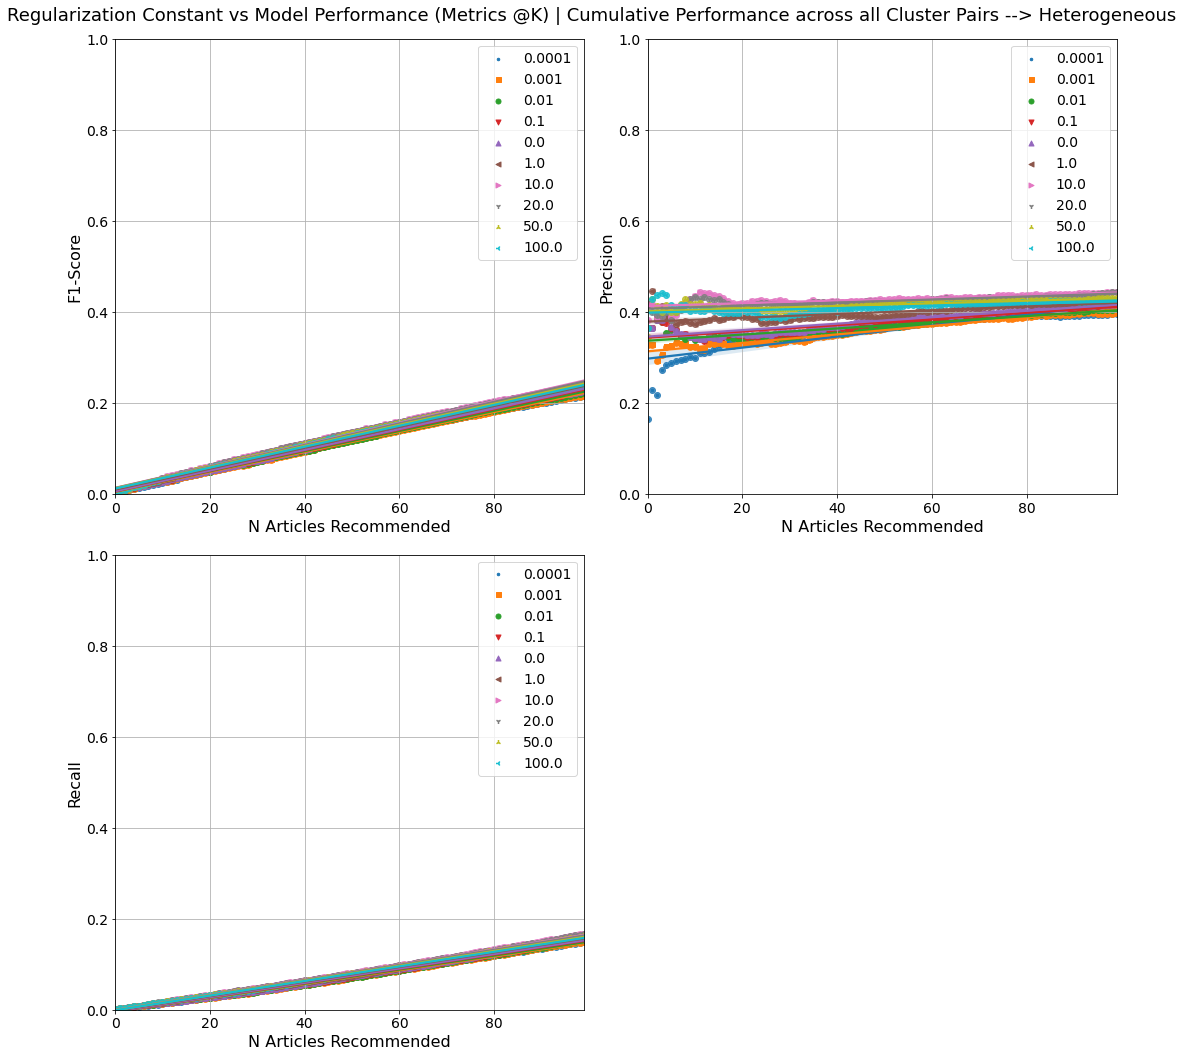


Finished running 'plot_regularization_vs_metrics_at_k' in 0.0622 mins


Finished running 'plot_regularization_vs_metrics_at_k_cumu' in 0.0624 mins



In [224]:
plot_regularization_vs_metrics_at_k_cumu(hetero_scores,
                                         regularization_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

In [225]:
homo_param_res = calculate_avg_precision_param_variation(homo_scores,
                                                         params=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

In [226]:
calculate_map_param_variation(homo_param_res)


Param : 0.0001
0.6622700381772209

Param : 0.001
0.6566853303688002

Param : 0.01
0.6464857165043488

Param : 0.1
0.6474206291339697

Param : 0.0
0.6482949534717184

Param : 1.0
0.6200293152938696

Param : 10.0
0.5789327709221256

Param : 20.0
0.5840369362515595

Param : 50.0
0.5953558073479597

Param : 100.0
0.6032737426048704


In [227]:
hetero_param_res = calculate_avg_precision_param_variation(hetero_scores,
                                                         params=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

In [228]:
calculate_map_param_variation(hetero_param_res)


Param : 0.0001
0.35709039755236377

Param : 0.001
0.3591762905821966

Param : 0.01
0.3698962484504634

Param : 0.1
0.377107085994089

Param : 0.0
0.3806303285464514

Param : 1.0
0.39905809115965923

Param : 10.0
0.4276561419339934

Param : 20.0
0.4234210368825537

Param : 50.0
0.41560603415064934

Param : 100.0
0.4104069071840465


## Baseline 5 : <a class="anchor" id="Learning_Rate_vs_Online_Setting_Performance"></a>

In [229]:
hetero_scores,df_het_res_100,df_het_res_500 = run_bs5_train_all(X=reduced_vectors,sample_df=sampled_df,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0

*************** CP = (423, 437) , LR = 0.001 ****************
SGDClassifier(eta0=0.001, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (423, 437) , LR = 0.01 ****************
SGDClassifier(eta0=0.01, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (423, 437) , LR = 0.1 ****************
SGDClassifier(eta0=0.1, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (423, 437) , LR = 1.0 ****************
SGDClassifier(eta0=1.0, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (423, 437) , LR = 10 ****************
SGDClassifier(eta0=10, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (423, 437) , LR = 15 ****************
SGDClassifier(eta0=15, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (423, 437) , LR = 20 *****

In [230]:
homo_scores,df_hom_res_100,df_hom_res_500 = run_bs5_train_all(X=reduced_vectors,sample_df=sampled_df,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0

*************** CP = (423, 437) , LR = 0.001 ****************
SGDClassifier(eta0=0.001, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (423, 437) , LR = 0.01 ****************
SGDClassifier(eta0=0.01, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (423, 437) , LR = 0.1 ****************
SGDClassifier(eta0=0.1, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (423, 437) , LR = 1.0 ****************
SGDClassifier(eta0=1.0, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (423, 437) , LR = 10 ****************
SGDClassifier(eta0=10, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (423, 437) , LR = 15 ****************
SGDClassifier(eta0=15, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (423, 437) , LR = 20 *****


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0007 mins



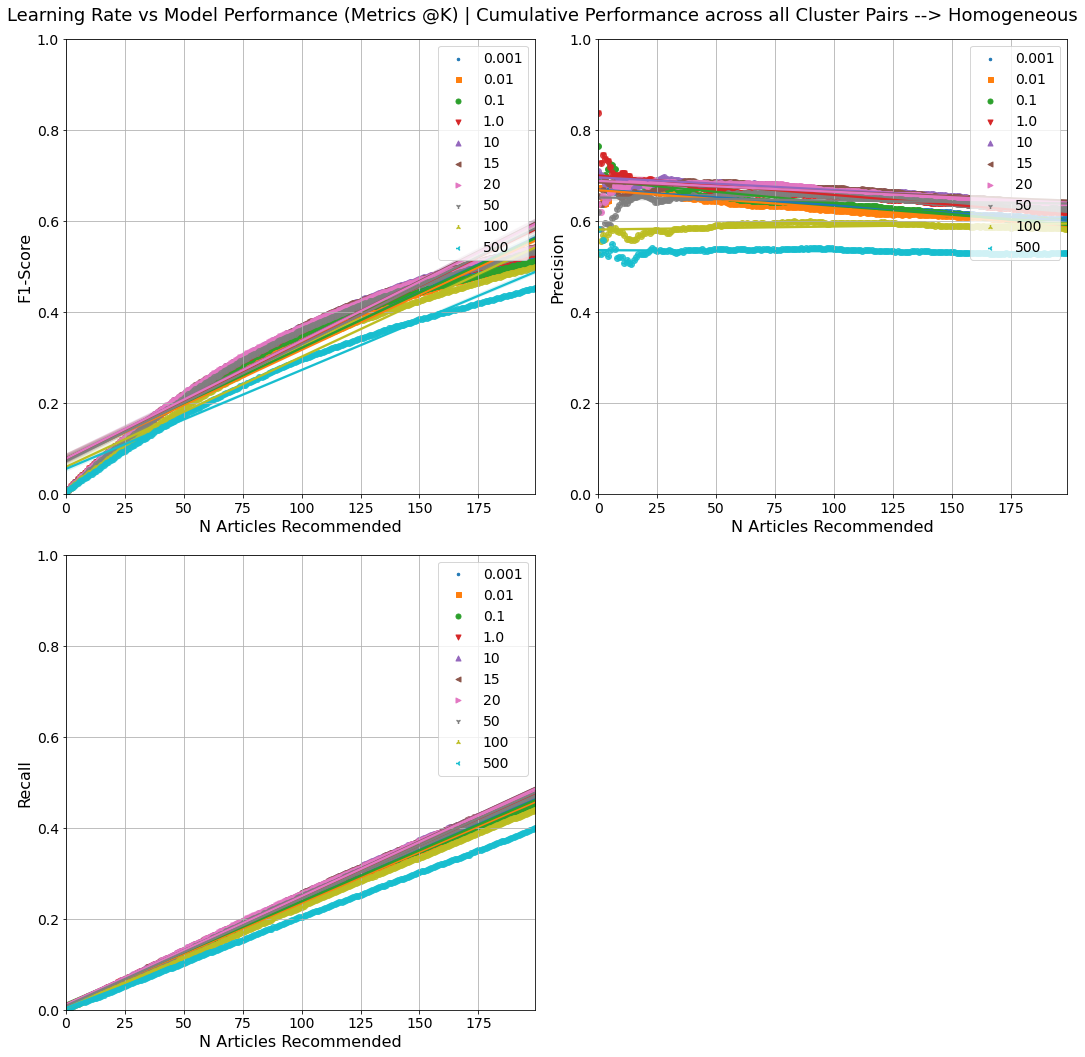


Finished running 'plot_lr_vs_metrics_at_k' in 0.0638 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0645 mins



In [231]:
plot_lr_vs_metrics_at_k_cumu(homo_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
                             user_type="Homogeneous")


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0003 mins



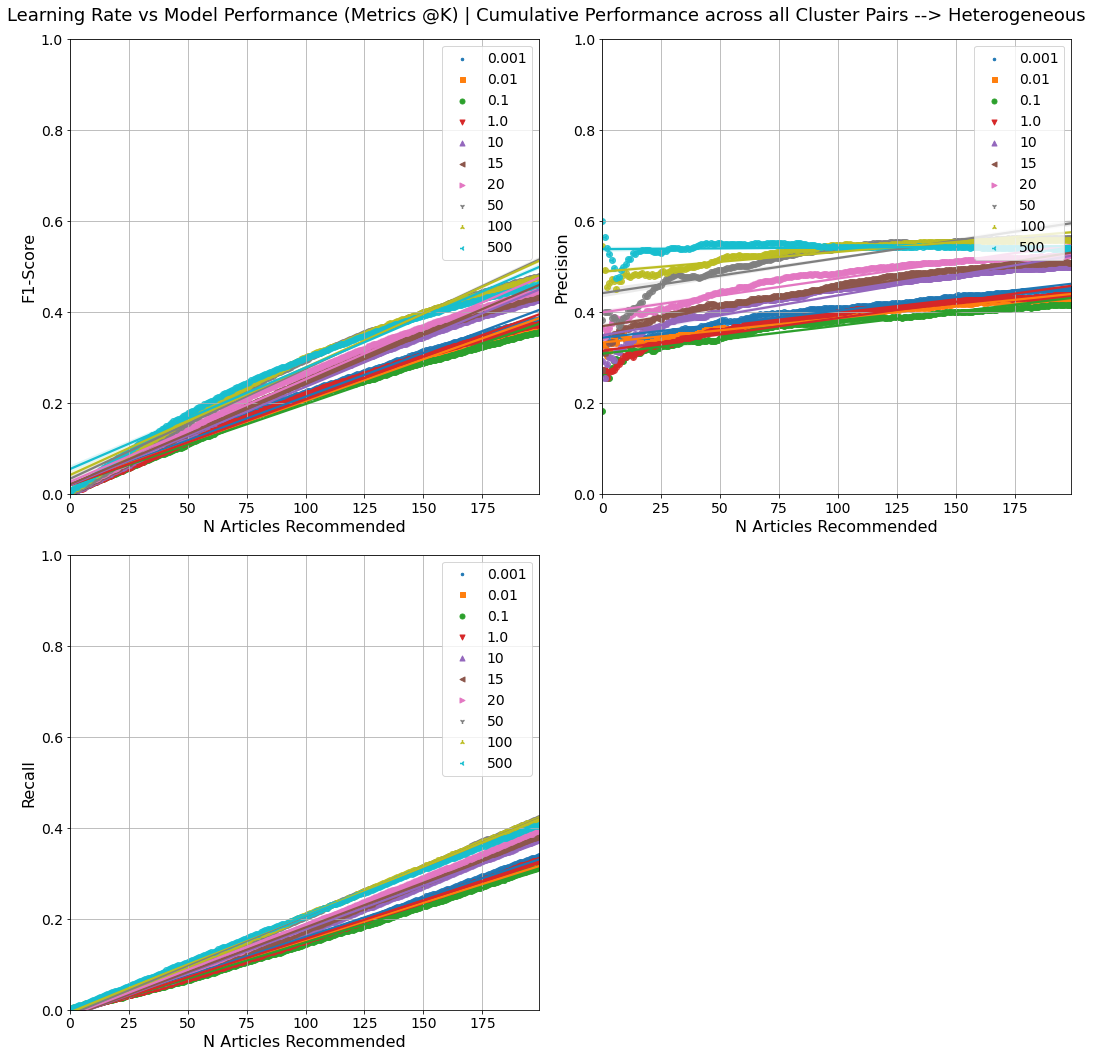


Finished running 'plot_lr_vs_metrics_at_k' in 0.0649 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0652 mins



In [232]:
plot_lr_vs_metrics_at_k_cumu(hetero_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

In [233]:
homo_param_res = calculate_avg_precision_param_variation(homo_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

In [234]:
calculate_map_param_variation(homo_param_res)


Param : 0.001
0.6344230767852505

Param : 0.01
0.6280924327155559

Param : 0.1
0.6392581908188883

Param : 1.0
0.6569191808489006

Param : 10
0.667717770060702

Param : 15
0.664224432647535

Param : 20
0.6637674386182755

Param : 50
0.6445738747453731

Param : 100
0.5872591850874923

Param : 500
0.5329640322458381


In [235]:
hetero_param_res = calculate_avg_precision_param_variation(hetero_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

In [236]:
calculate_map_param_variation(hetero_param_res)


Param : 0.001
0.4023818068623709

Param : 0.01
0.38586808895219976

Param : 0.1
0.3692111671845278

Param : 1.0
0.3858509765903898

Param : 10
0.4357428022513351

Param : 15
0.44925524285340995

Param : 20
0.47278150260639995

Param : 50
0.5177843944848909

Param : 100
0.531428681127791

Param : 500
0.541079996107237


## Baseline 6: <a class="anchor" id="Online_Setting_Mixed_Data_Performance"></a>

In [11]:
hetero_scores = run_bs6_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [12]:
homo_scores = run_bs6_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [13]:
# homo_scores.keys()

In [14]:
# plot_mixed_data_performance_per_cluster(homo_scores[(585, 712)],hetero_scores[(585, 712)])


Finished running 'combine_scores_mixed_data' in 0.0001 mins


Finished running 'combine_scores_mixed_data' in 0.0001 mins



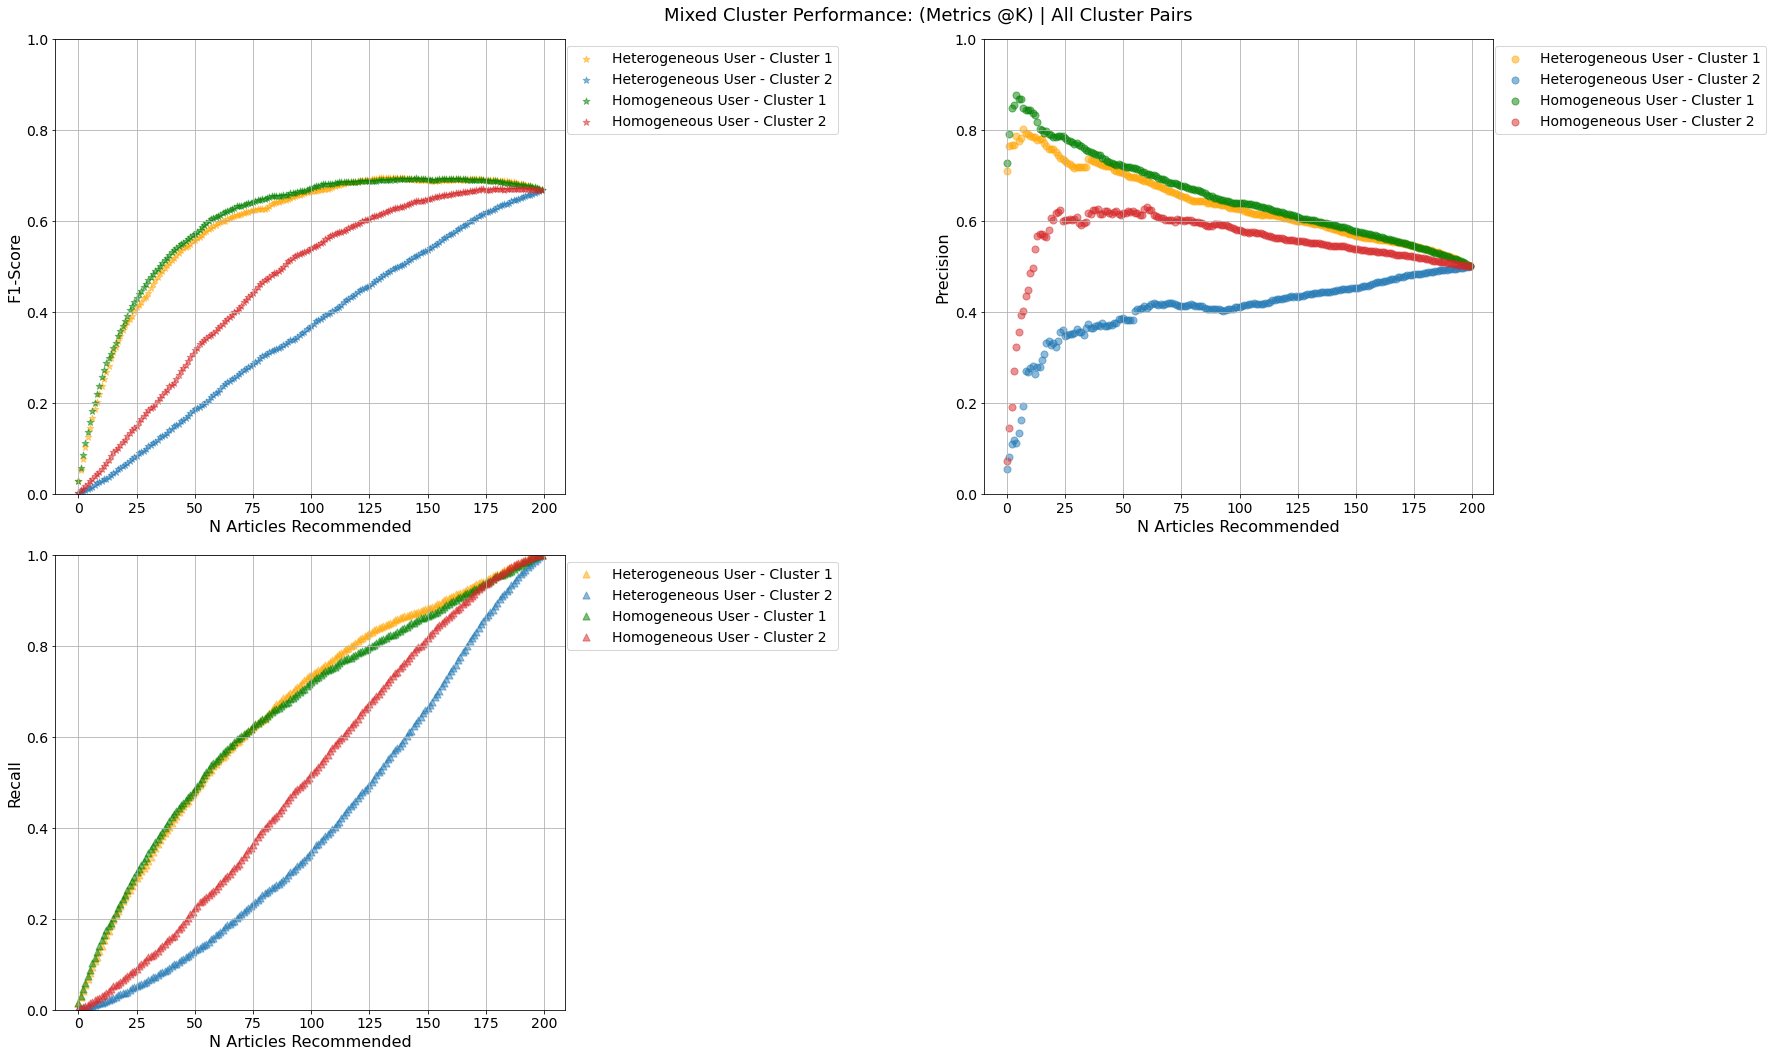


Finished running 'plot_mixed_data_performance_per_cluster' in 0.0116 mins


Finished running 'plot_mixed_cluster_cumulative_per_cluster' in 0.0119 mins



In [15]:
plot_mixed_cluster_cumulative_per_cluster(homo_scores,hetero_scores)

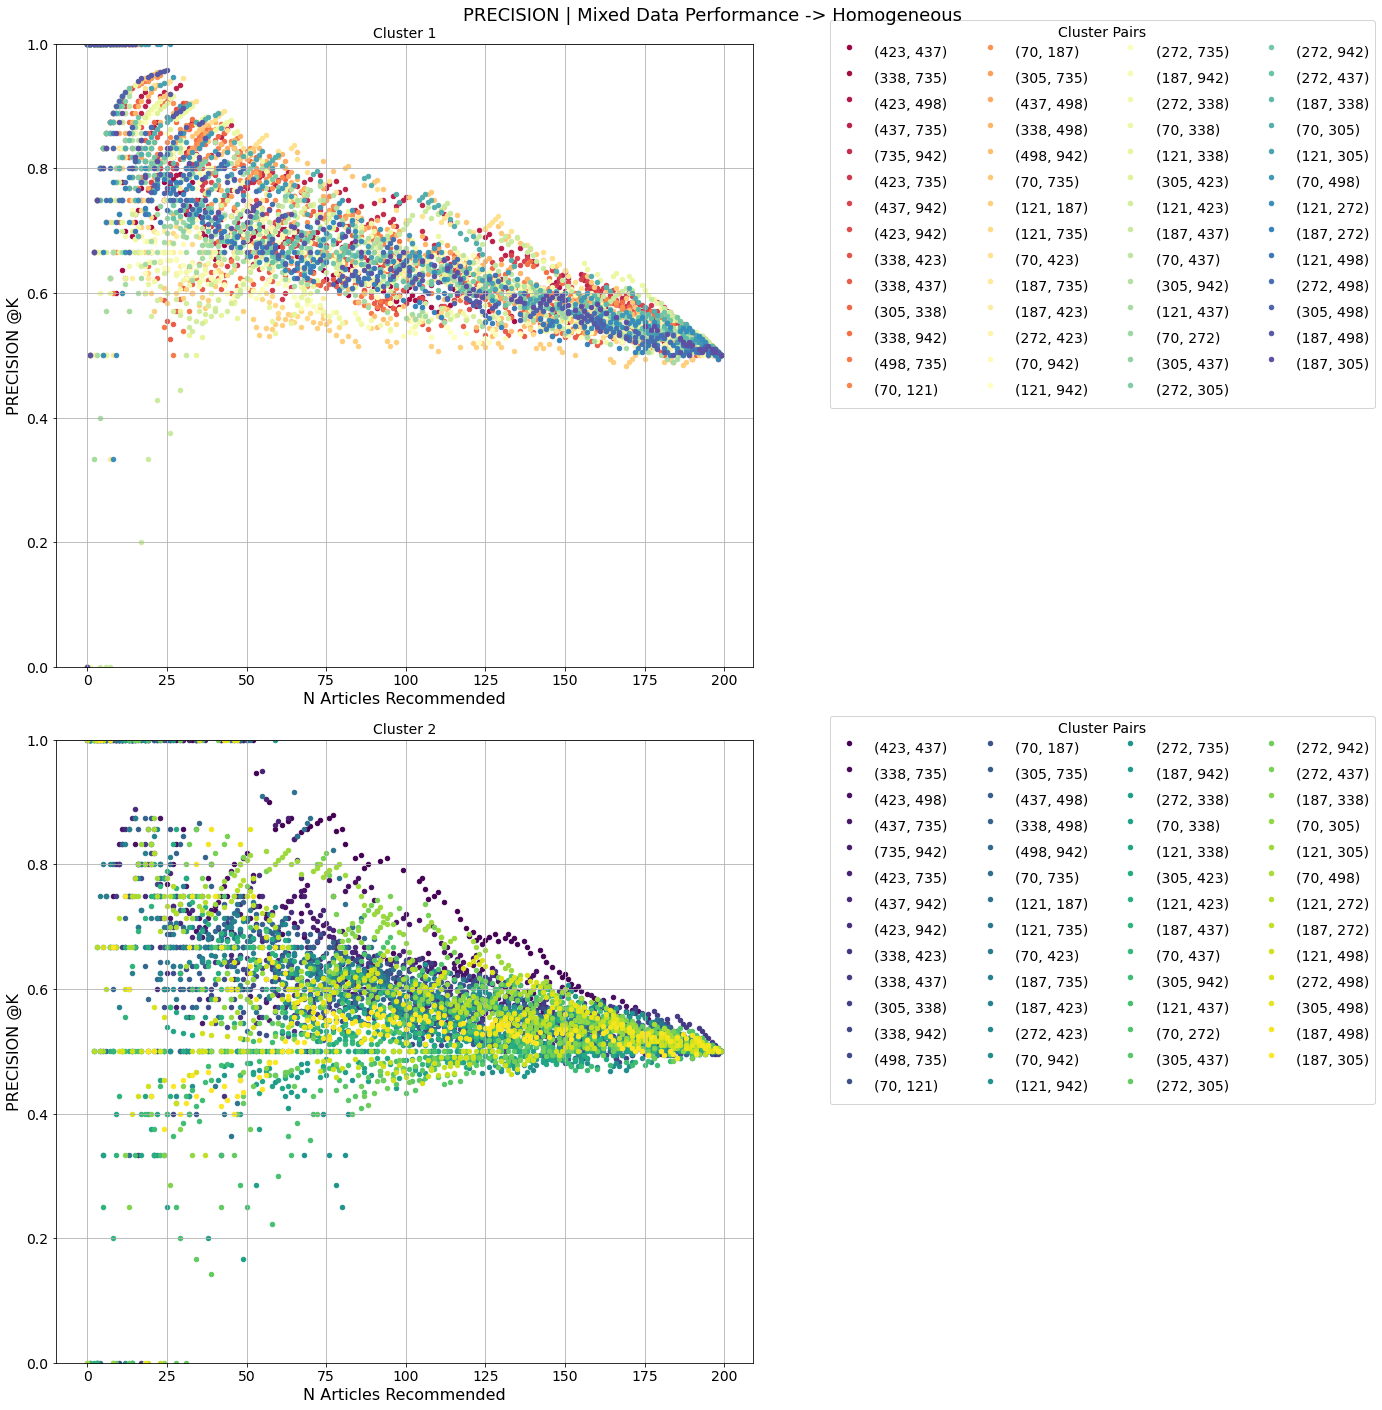


Finished running 'plot_mixed_data_all_cp_perf' in 0.0773 mins



In [16]:
plot_mixed_data_all_cp_perf(scores_cp=homo_scores,user_type="Homogeneous",metric="precision")

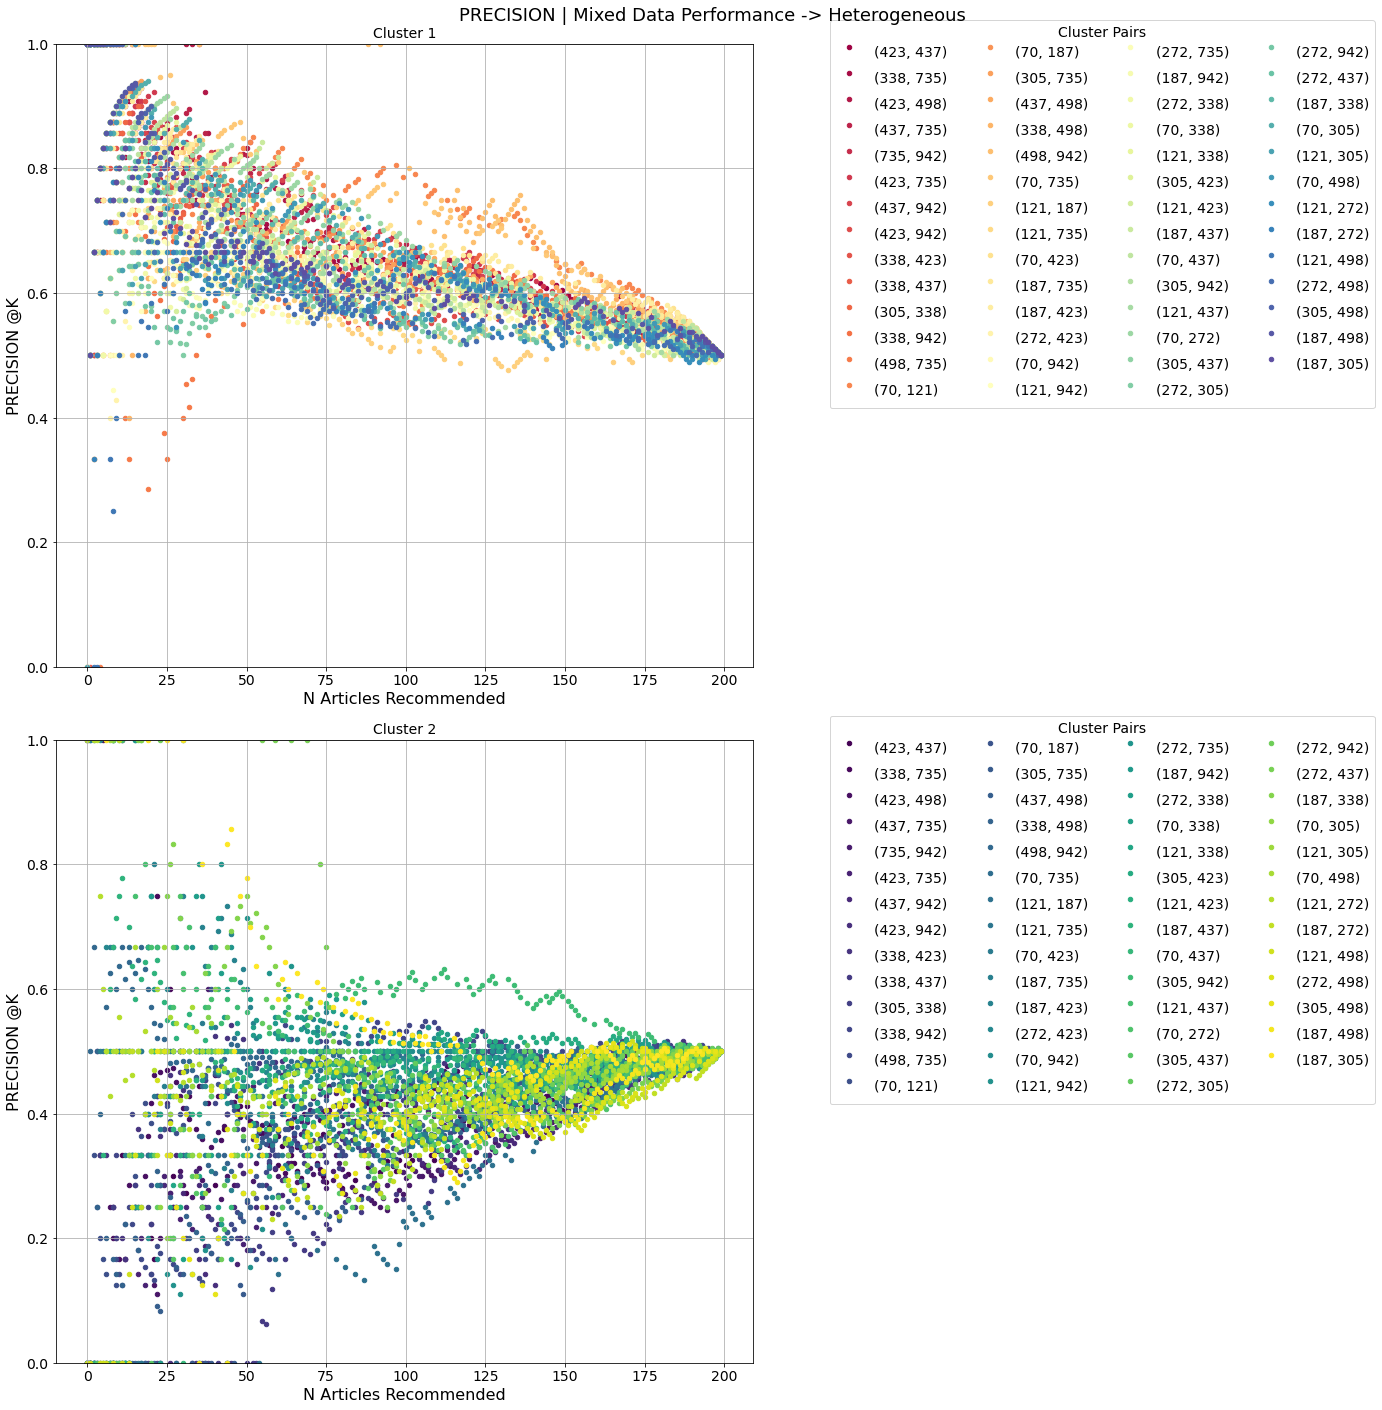


Finished running 'plot_mixed_data_all_cp_perf' in 0.0764 mins



In [17]:
plot_mixed_data_all_cp_perf(scores_cp=hetero_scores,user_type="Heterogeneous",metric="precision")

In [18]:
avg_presc_homo, avg_presc_homo_c1, avg_presc_homo_c2 = calculate_avg_precision(homo_scores,mode="mixed")

In [19]:
np.mean(avg_presc_homo)

0.6326318657938382

In [20]:
np.mean(avg_presc_homo_c1)

0.6536732182565018

In [21]:
np.mean(avg_presc_homo_c2)

0.5545800936812625

In [22]:
avg_presc_hetero,avg_presc_hetero_c1, avg_presc_hetero_c2 = calculate_avg_precision(hetero_scores,mode="mixed")

In [23]:
np.mean(avg_presc_hetero)

0.5656342152497834

In [24]:
np.mean(avg_presc_hetero_c1)

0.6363656056727881

In [25]:
np.mean(avg_presc_hetero_c2)

0.40668675922075037

## Baseline 7 : <a class="anchor" id="Learning_Rate_vs_Online_Setting_Mixed_Data_Performance"></a>

In [250]:
hetero_scores = run_bs7_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [251]:
homo_scores = run_bs7_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [252]:
# plot_lr_vs_metrics_at_k_mixed(homo_scores[(585, 712)],
#                                     lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],user_type="Homogeneous")

In [253]:
# plot_lr_vs_metrics_at_k_mixed(hetero_scores[(585, 712)],
#                                     lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0004 mins



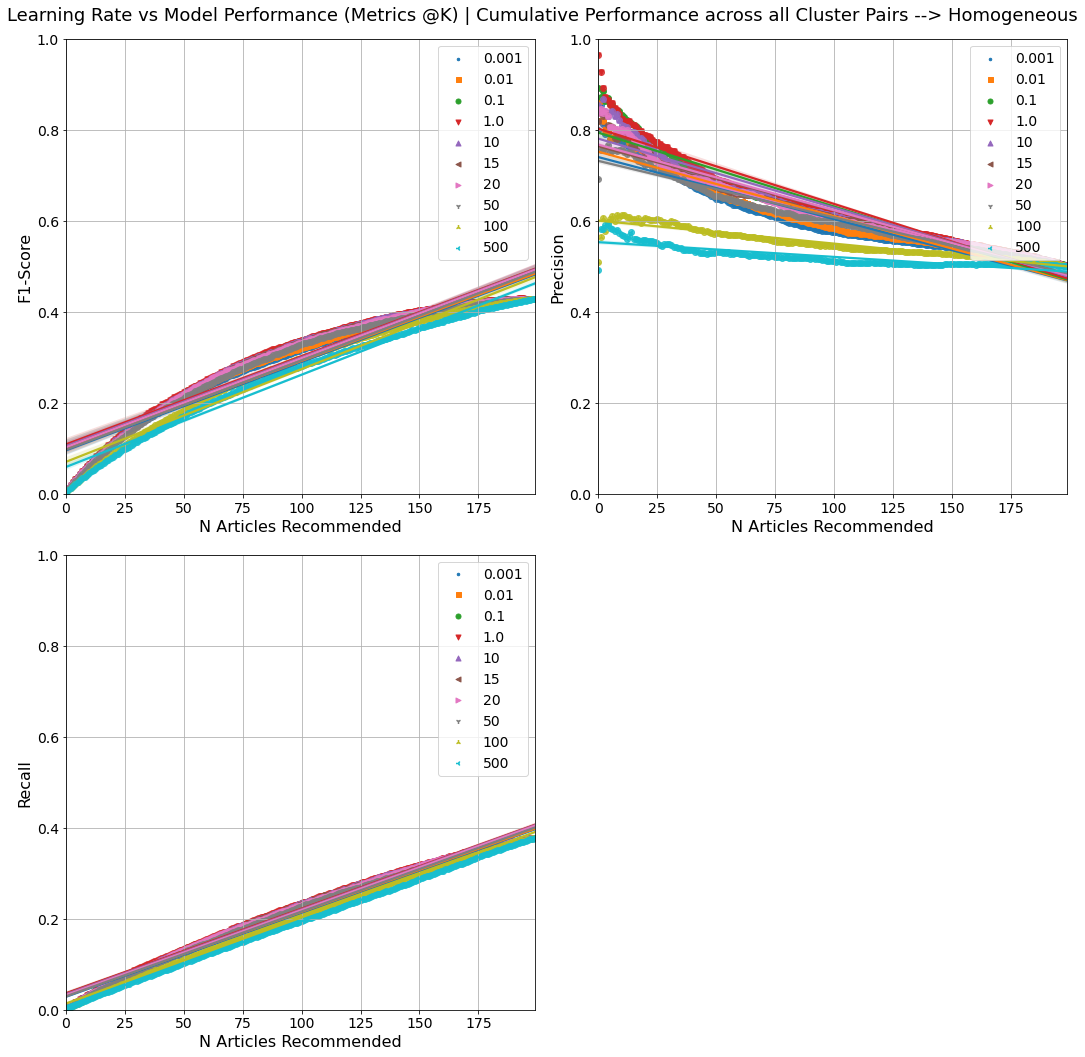


Finished running 'plot_lr_vs_metrics_at_k' in 0.0672 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0677 mins



In [254]:
plot_lr_vs_metrics_at_k_cumu(homo_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
                             user_type="Homogeneous",mixed_data=True)


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0004 mins



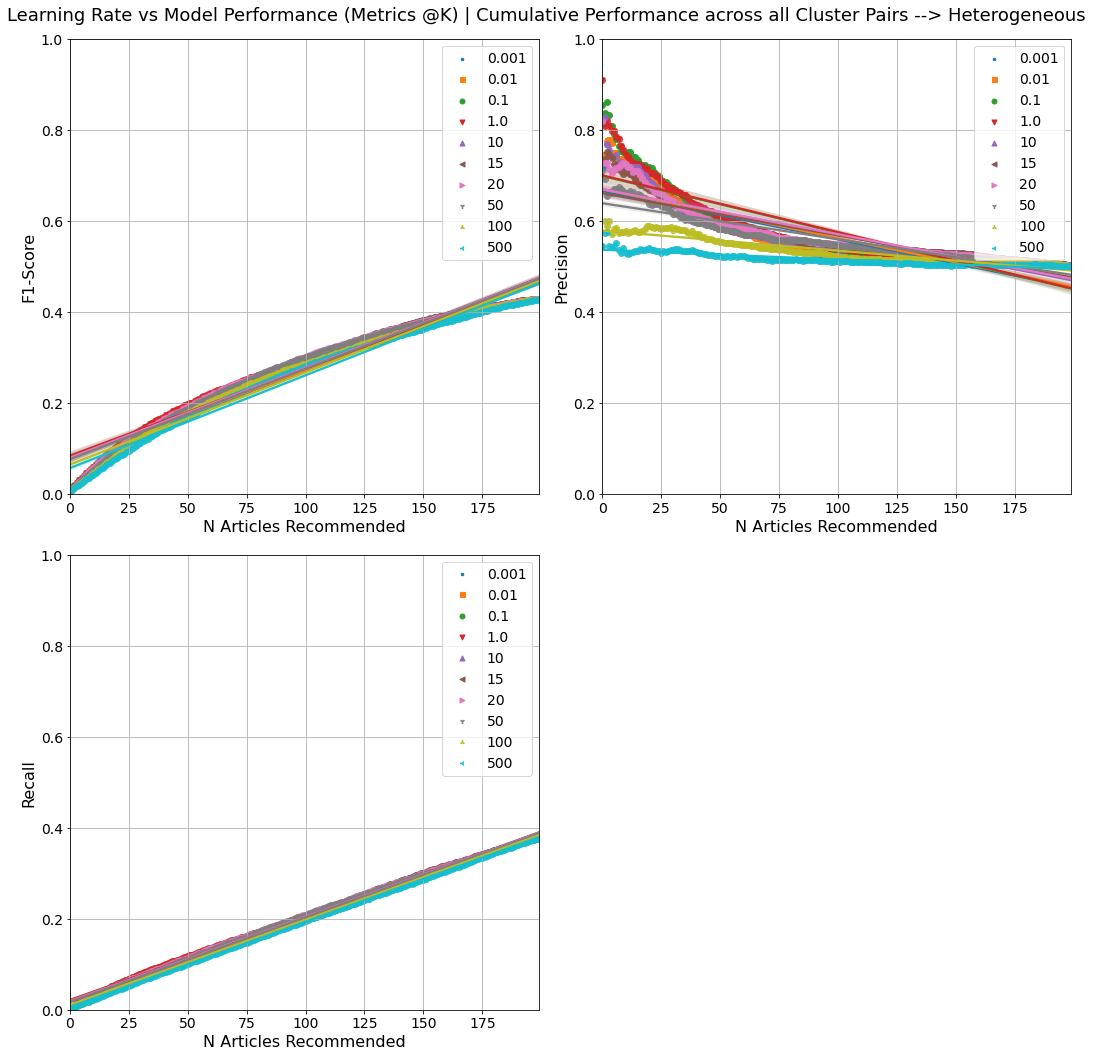


Finished running 'plot_lr_vs_metrics_at_k' in 0.0733 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0737 mins



In [255]:
plot_lr_vs_metrics_at_k_cumu(hetero_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],mixed_data=True)

In [256]:
#  plot_mixed_data_all_cp_precis_lr(scores_=homo_scores,
#                              lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
#                              user_type="Homogeneous",metric="precision")

In [257]:
#  plot_mixed_data_all_cp_precis_lr(scores_=hetero_scores,
#                              lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
#                              user_type="Heterogeneous",metric="precision")

In [258]:
homo_param_res = calculate_avg_precision_param_variation(homo_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],mode="mixed")

In [259]:
calculate_map_param_variation(homo_param_res,mode="mixed")


Param : 0.001
0.6043004931759368
c1 MAP : 
0.6143620241425414
c2 MAP : 
0.4739504764167846

Param : 0.01
0.6106278069956048
c1 MAP : 
0.624828145795815
c2 MAP : 
0.486716763597711

Param : 0.1
0.6322156793828986
c1 MAP : 
0.6481535404704583
c2 MAP : 
0.5416087716468375

Param : 1.0
0.6377837251252935
c1 MAP : 
0.6541995633085015
c2 MAP : 
0.5550188325953396

Param : 10
0.6293193057243966
c1 MAP : 
0.6550567474398165
c2 MAP : 
0.5480133138840035

Param : 15
0.6231503454860797
c1 MAP : 
0.6476639792717588
c2 MAP : 
0.5419626984748237

Param : 20
0.6238607352497734
c1 MAP : 
0.6491572712609088
c2 MAP : 
0.5361128943822732

Param : 50
0.6079815598617461
c1 MAP : 
0.6265673597853634
c2 MAP : 
0.5301633988094081

Param : 100
0.5500644864724552
c1 MAP : 
0.552071262133884
c2 MAP : 
0.48626350688122294

Param : 500
0.5207824070953536
c1 MAP : 
0.5123883952205422
c2 MAP : 
0.5069709673560525


In [260]:
hetero_param_res = calculate_avg_precision_param_variation(hetero_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],mode="mixed")

In [261]:
calculate_map_param_variation(hetero_param_res,mode="mixed")


Param : 0.001
0.5597277125046822
c1 MAP : 
0.5989198726009655
c2 MAP : 
0.34548880600159304

Param : 0.01
0.562520076978102
c1 MAP : 
0.612960330834301
c2 MAP : 
0.3522635893034228

Param : 0.1
0.5747089057364818
c1 MAP : 
0.6474605779669469
c2 MAP : 
0.3640846156454596

Param : 1.0
0.5757411685263772
c1 MAP : 
0.6453903124391795
c2 MAP : 
0.3644212812836841

Param : 10
0.5695525229224002
c1 MAP : 
0.6445689470370284
c2 MAP : 
0.3953725824458017

Param : 15
0.5681649144668564
c1 MAP : 
0.6373410905970219
c2 MAP : 
0.4132008777617257

Param : 20
0.57089816256256
c1 MAP : 
0.6311323557887407
c2 MAP : 
0.41206181690072424

Param : 50
0.5599155047573031
c1 MAP : 
0.6026698725783659
c2 MAP : 
0.4306375186378794

Param : 100
0.5346604354434229
c1 MAP : 
0.5485474222019998
c2 MAP : 
0.4481341303631379

Param : 500
0.5151085373721187
c1 MAP : 
0.5095341230319131
c2 MAP : 
0.4903235204005769
